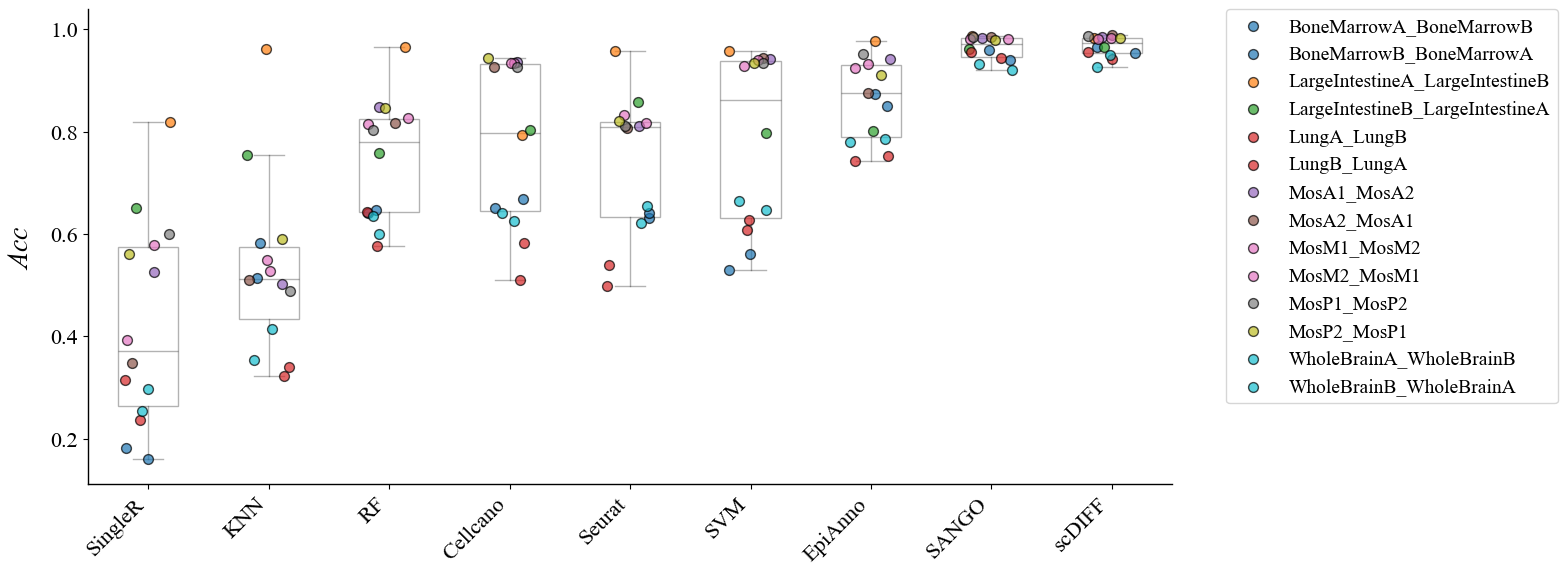

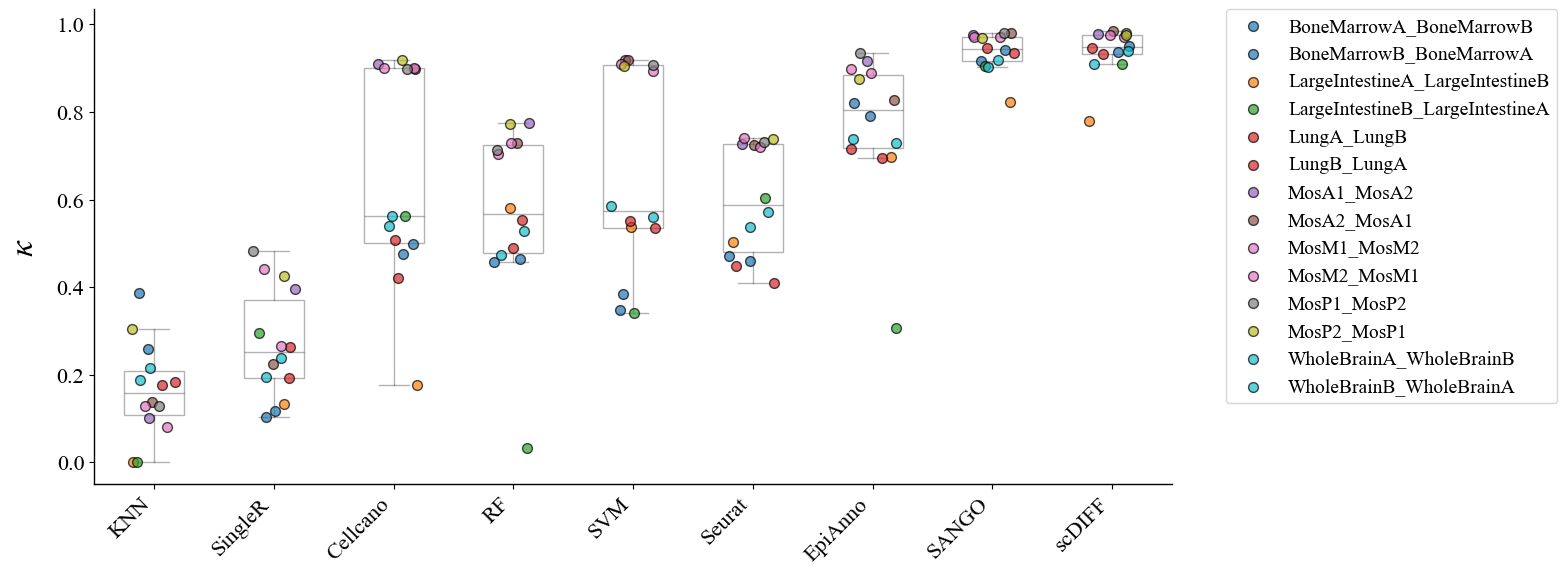

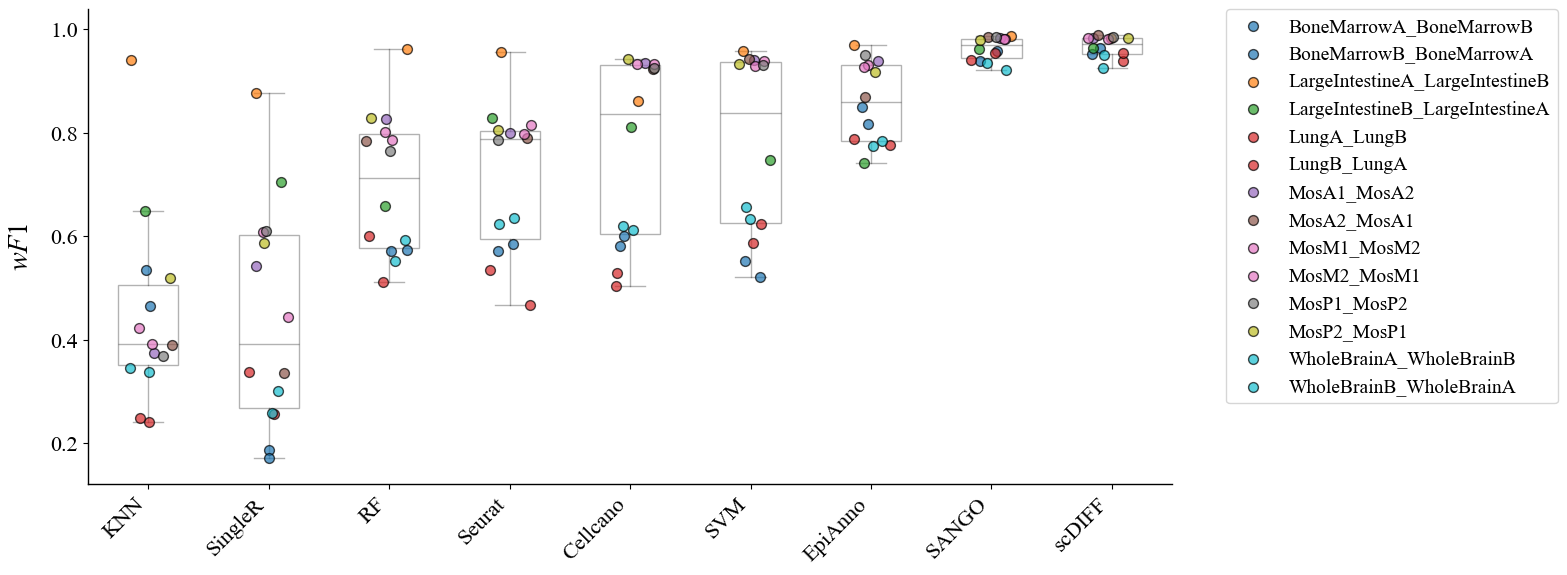

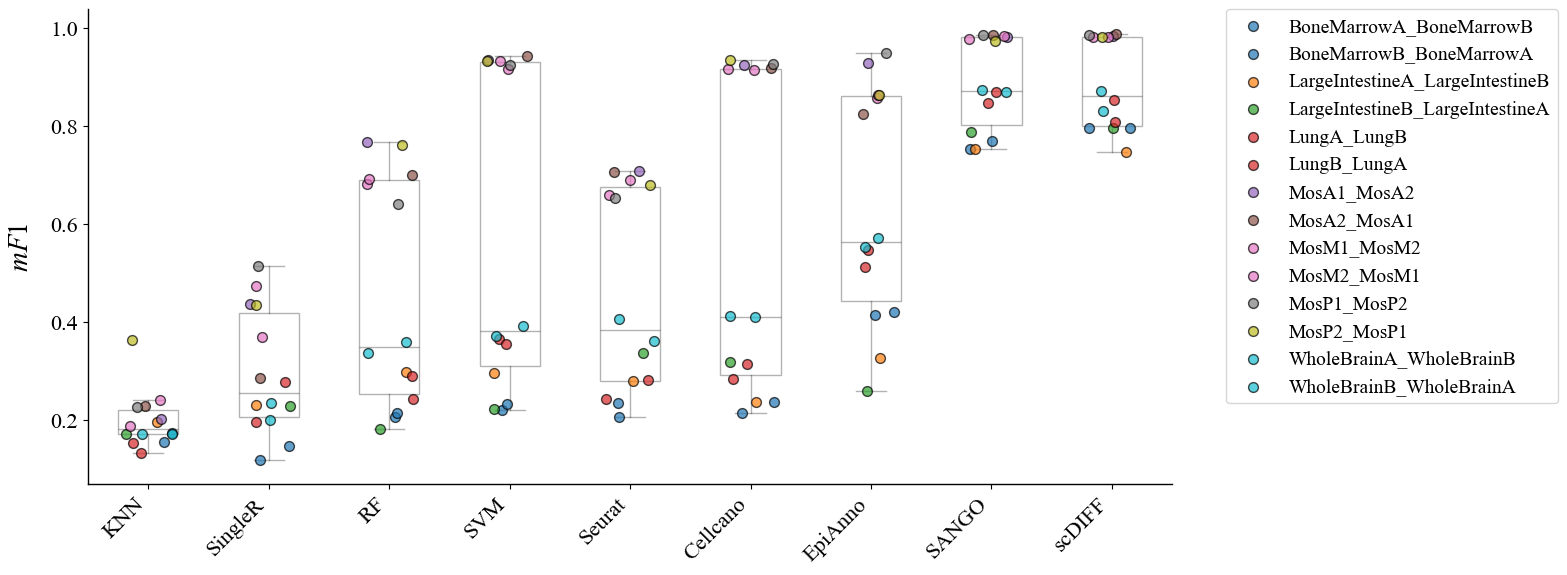

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def combine_results(base_dir):
    """
    Combine result files from all methods and process method names
    """
    all_data = []
    
    # Get all csv files
    method_files = [f for f in os.listdir(base_dir) if f.endswith('.csv')]
    
    for file in method_files:
        # Get method name from filename and remove _res suffix
        method = file.replace('.csv', '').replace('_res', '')
        
        # Read data
        df = pd.read_csv(os.path.join(base_dir, file))
        df['Method'] = method
        all_data.append(df)
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

def create_comparison_plot(combined_df, metric='ACC', figsize=(16, 6)):
    """
    Create a combination of box plots and scatter plots, with 'scDIFF' method always on the rightmost position
    """
    # Define mapping from metric names to paper format
    metric_labels = {
        'ACC': r'$Acc$',  # Accuracy
        # 'Kappa': r'$\kappa$',  # Cohen's kappa coefficient
        'Kappa': r'$\kappa$',  # Cohen's kappa coefficient
        'Weighted_F1': r'$wF1$',  # Weighted F1 score
        'Macro_F1': r'$mF1$'  # Macro F1 score
    }
    
    # Get corresponding label, use original name if not found
    metric_display = metric_labels.get(metric, metric.replace('_', ' '))
    
    # Calculate median for each method and sort, but exclude 'scDIFF' method
    methods = combined_df['Method'].unique().tolist()
    other_methods = [m for m in methods if m != 'scDIFF']
    
    # Sort other methods by median values
    median_values = combined_df[combined_df['Method'].isin(other_methods)].groupby('Method')[metric].median().sort_values()
    methods_ordered = median_values.index.tolist()
    
    # Add 'scDIFF' method to the end
    if 'scDIFF' in methods:
        methods_ordered.append('scDIFF')
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set default font to Times New Roman
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'] + plt.rcParams['font.serif'],
        'mathtext.fontset': 'custom',
        'mathtext.rm': 'Times New Roman',
        'mathtext.it': 'Times New Roman:italic',
        'mathtext.bf': 'Times New Roman:bold',
        'font.size': 16,
        'axes.titlesize': 16,
        'axes.labelsize': 16,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16
    })

    # Set background and axes
    ax.set_facecolor('white')
    
    # Only show bottom and left axis lines and set width
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set width of visible axis lines
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(1.0)
    
    # Set color scheme
    n_datasets = len(combined_df['Dataset'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, n_datasets))
    
    # Create sorted data
    plot_data = [combined_df[combined_df['Method'] == method][metric]
                for method in methods_ordered]
    
    # Draw box plots (unified line style)
    box_style = dict(color='black', linewidth=1.0, alpha=0.3)
    bp = ax.boxplot(plot_data,
                    patch_artist=True,
                    medianprops=box_style,
                    boxprops=dict(facecolor='white', **box_style),
                    whiskerprops=box_style,
                    capprops=box_style,
                    showfliers=False,
                    zorder=1)
    
    # Draw scatter points
    for i, dataset in enumerate(sorted(combined_df['Dataset'].unique())):
        dataset_data = combined_df[combined_df['Dataset'] == dataset]
        
        # Create sorted x-coordinates and corresponding values
        for j, method in enumerate(methods_ordered, 1):
            if method in dataset_data['Method'].values:
                # Create a random x-coordinate offset for each point
                x_coord = j + np.random.uniform(-0.2, 0.2)
                y_value = dataset_data[dataset_data['Method'] == method][metric].iloc[0]
                
                # Use dataset color to draw scatter points
                ax.scatter(x_coord, y_value,
                          label=dataset if j == 1 else "",  # Only add label on first occurrence
                          color=colors[i],
                          edgecolor='black',
                          linewidth=1,
                          alpha=0.7,
                          s=50,
                          zorder=2)
    
    # Set figure properties - use paper format labels
    # ax.set_ylabel(metric_display, fontsize=22, fontweight='bold', labelpad=12)

    if metric == 'Kappa':
        ax.set_ylabel(metric_display, fontsize=24, fontweight='bold', labelpad=12)
    else:
        ax.set_ylabel(metric_display, fontsize=20, fontweight='bold', labelpad=12)
    # Set x-axis ticks and labels
    ax.set_xticks(range(1, len(methods_ordered) + 1))
    ax.set_xticklabels(methods_ordered, rotation=45, ha='right')
    
    # Set y-axis range, leave some space
    ymin, ymax = combined_df[metric].min(), combined_df[metric].max()
    ax.set_ylim(ymin - 0.05, ymax + 0.05)
    
    # Add legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
             fontsize=14, borderaxespad=0.)
    
    # Adjust layout
    plt.tight_layout(pad=1.0)

    # Save figure
    # plt.savefig(f'comparison_{metric}.svg', pad_inches=2)
    plt.show()

# Usage example
if __name__ == "__main__":
    # Combine all results
    combined_df = combine_results("/home/daozhang/Draw_picture/result")
    
    # Create comparison plots for different metrics
    metrics = ['ACC', 'Kappa', 'Weighted_F1', 'Macro_F1']
    for metric in metrics:
        create_comparison_plot(combined_df, metric=metric)